In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn as sk
import seaborn as sns
from sklearn import linear_model
from sklearn import svm

%matplotlib notebook

In [2]:
def create_sign_func(vector):
    def sign_func(p):
        x = np.dot(vector, [1, p[0], p[1]])
        return int(np.sign(x))
    return sign_func


def convert_to_explicit_eq(vector):
    return np.poly1d([-vector[1]/vector[2], -vector[0]/vector[2]])


def generate_sample(training_size, test_size):
    p1 = np.random.uniform(-1, 1, 2)
    p2 = np.random.uniform(-1, 1, 2)
    
    v = p1 - p2
    n = (-v[1], v[0])
    line = np.array([-n[0]*p1[0] - n[1]*p1[1], n[0], n[1]])
    target_func = create_sign_func(line)
    
    sample = pd.DataFrame({
        'x': np.random.uniform(-1, 1, training_size + test_size),
        'y': np.random.uniform(-1, 1, training_size + test_size),
    })

    sample['sign'] = sample[['x', 'y']].apply(target_func, axis = 1)
    
    
    return sample, line, target_func

In [3]:
sample, line, target_func = generate_sample(100, 100)
training_sample = sample[:100]
training_sample.head()

,x,y,sign
0,-0.181186,-0.511417,-1
1,-0.533978,-0.568699,-1
2,0.801869,-0.149340,1
3,0.191715,0.515041,-1
4,0.595172,0.128213,1


In [4]:
perceptron = linear_model.Perceptron()
perceptron.fit(training_sample[['x', 'y']], training_sample.sign)
perceptron_explicit = convert_to_explicit_eq([perceptron.intercept_[0], perceptron.coef_[0][0], perceptron.coef_[0][1]])

svc = svm.SVC(kernel='linear', C=1e10)
svc.fit(training_sample[['x', 'y']], training_sample.sign)
svc_explicit = convert_to_explicit_eq([svc.intercept_[0], svc.coef_[0][0], svc.coef_[0][1]])

line_explicit = convert_to_explicit_eq(line)

print("Target function: ", line_explicit)
print("Perceptron: ", perceptron_explicit)
print("SVM: ", svc_explicit)

Target function:   
4.457 x - 2.276
Perceptron:   
3.594 x - 1.863
SVM:   
4.152 x - 2.222


<IPython.core.display.Javascript object>


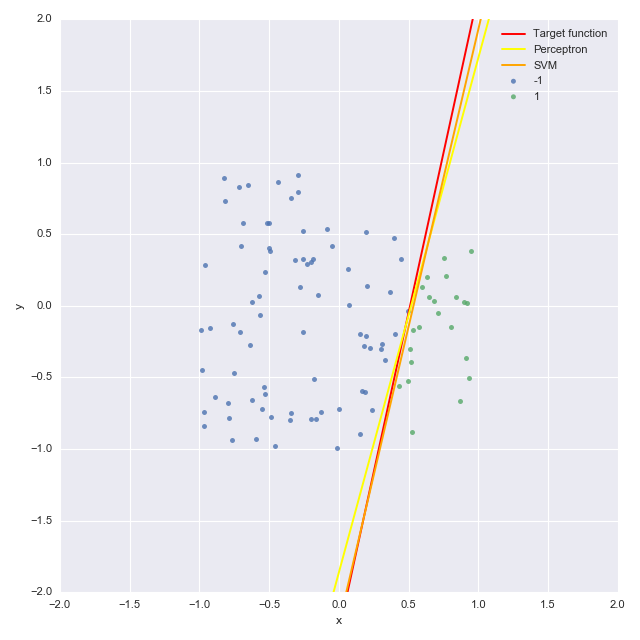

In [5]:
sns.lmplot('x', 'y', data = training_sample, hue='sign', fit_reg=False, legend_out=False, size = 8)
x = np.linspace(-2, 2, 100)
plt.xlim(-2, 2)
plt.ylim(-2, 2)
plt.plot(x, line_explicit(x), color="red", label="Target function")
plt.plot(x, perceptron_explicit(x), color="yellow", label="Perceptron")
plt.plot(x, svc_explicit(x), color="orange", label="SVM")
plt.legend()

In [42]:
def perceptron_algorithm(sample, initial_vector):
    h = initial_vector
    n = sample.x.size
    i = j = num_it = 0
    while(j < n):
        sign = sample.iloc[i].sign
        dot_product = np.dot(h, [1, sample.iloc[i].x, sample.iloc[i].y])
        if dot_product > 0: new_sign = 1
        elif dot_product < 0: new_sign = -1
        else: new_sign = 0
        if new_sign == sign:
            i, j = (i + 1) % n, j + 1
        else:
            h = h + sign * np.array([1, sample.iloc[i].x, sample.iloc[i].y])
            i, j = (i + 1) % n, 0
            num_it += 1
    
    return h, num_it


def run_experiment(training_size, test_size):
    runs = 100
    result = 0
    num_of_svm = 0
    
    for _ in range(runs):
        sample, line, target_func = generate_sample(training_size, test_size)
        training_sample, test_sample = None, None
        all_equal = True
        while all_equal:
            training_sample = sample.sample(training_size)
            test_sample=sample.drop(training_sample.index)
            if len(set(training_sample.sign)) > 1: all_equal = False
        
        perceptron = linear_model.Perceptron()
        perceptron.fit(training_sample[['x', 'y']], training_sample.sign)
        perceptron_sign_function = create_sign_func([perceptron.intercept_[0], perceptron.coef_[0][0], perceptron.coef_[0][1]])

        #perceptron, _ = perceptron_algorithm(training_sample, [0, 0, 0])
        #perceptron_sign_function = create_sign_func(perceptron)
        
        svc = svm.SVC(kernel='linear', C=1e100)
        svc.fit(training_sample[['x', 'y']], training_sample.sign)
        svc_sign_function = create_sign_func([svc.intercept_[0], svc.coef_[0][0], svc.coef_[0][1]])
        
        perceptron_score = sk.metrics.accuracy_score(test_sample.sign, test_sample[['x', 'y']].apply(perceptron_sign_function, axis = 1))
        svc_score = sk.metrics.accuracy_score(test_sample.sign, test_sample[['x', 'y']].apply(svc_sign_function, axis = 1))
        
        if svc_score > perceptron_score: result += 1
        num_of_svm += len(svc.support_vectors_)
        
    print(result / runs)
    print(num_of_svm / runs)

### Solutions to question 8:

In [43]:
run_experiment(10, 1000)

0.65
2.85


### Solutions to questions 9 and 10:

In [44]:
run_experiment(100, 1000)

0.86
3.01
